# Определение возраста покупателей

Цель этого проекта - создание и обучение нейросети, построенной на основе архитектуры ResNet, для определения возраста людей по их фотографии. Определение возраста - задача регрессии, а значит оценивать модель необходимо по метрике MAE (среднее абсолютное отклонение). Для успешного выполнения необходимо достичь MAE меньше 7.0.

In [45]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

## Исследовательский анализ данных

In [12]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

display(labels.head())

print('Количество изображений в датасете:', labels.shape[0])

features, target = next(datagen_flow)

print('Размер изображений:', features[0].shape)

Found 7591 validated image filenames.


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Количество изображений в датасете: 7591
Размер изображений: (224, 224, 3)


В распоряжении имеется 7591 изображение размером 224х224х3. 7500 изображений - не так много для успешного обучения нейросети. Из-за малого количества данных она может переобучиться, поэтому для обучения можно использовать аугментацию для увеличения выборки.

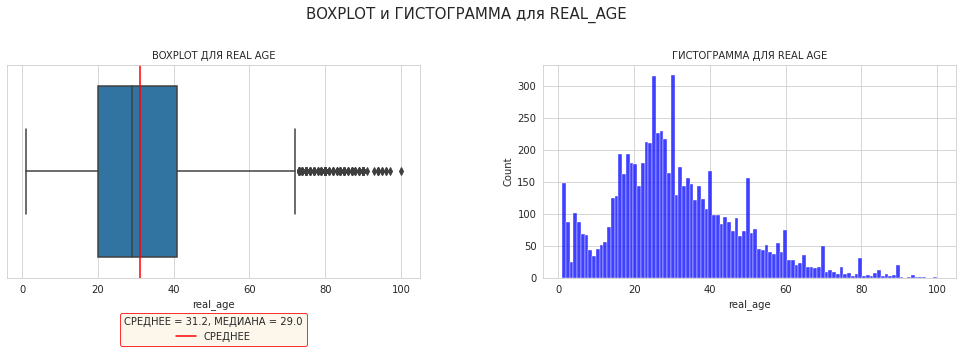

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [74]:
col = 'real_age'
num_region = None
plt.figure(figsize=[17, 20])
plt.subplots_adjust(top=0.94, wspace=0.3, hspace=0.5)
plt.suptitle('BOXPLOT и ГИСТОГРАММА для REAL_AGE', fontsize=15)

plt.subplot(4, 2, 1)
sns.set_style('whitegrid')
plt.title(f'BOXPLOT ДЛЯ REAL AGE', fontsize=10)
sns.set_style('whitegrid')
sns.boxplot(x=labels['real_age'], orient='h');
plt.axvline(np.mean(labels['real_age']), 
            color='r', 
            linestyle='-',
            label='СРЕДНЕЕ')
plt.legend(title=f'СРЕДНЕЕ = {np.mean(labels[col]):.1f}, МЕДИАНА = {np.median(labels[col]):.1f}', 
           loc='center', 
           edgecolor = 'r',
           facecolor = 'oldlace',
           bbox_to_anchor=(0.5, -0.24))

plt.subplot(4, 2, 2)
sns.set_style('whitegrid')
plt.title(f'ГИСТОГРАММА ДЛЯ REAL AGE', fontsize=10)
sns.histplot(labels['real_age'], color='b', kde=False, bins=100);

plt.show()

display(labels.describe())

Минимальный и максимальный возраст людей на фотографиях - 1 и 100 лет соответственно. Медиана - 29 лет, среднее - 31 год. Очень мало данных для возраста выше 70 лет. <br>
На гистограмме имеются пики почти для каждой "круглой" даты (30, 40, 50 и тд. лет). Также мало данных для возраста 7-13 лет.

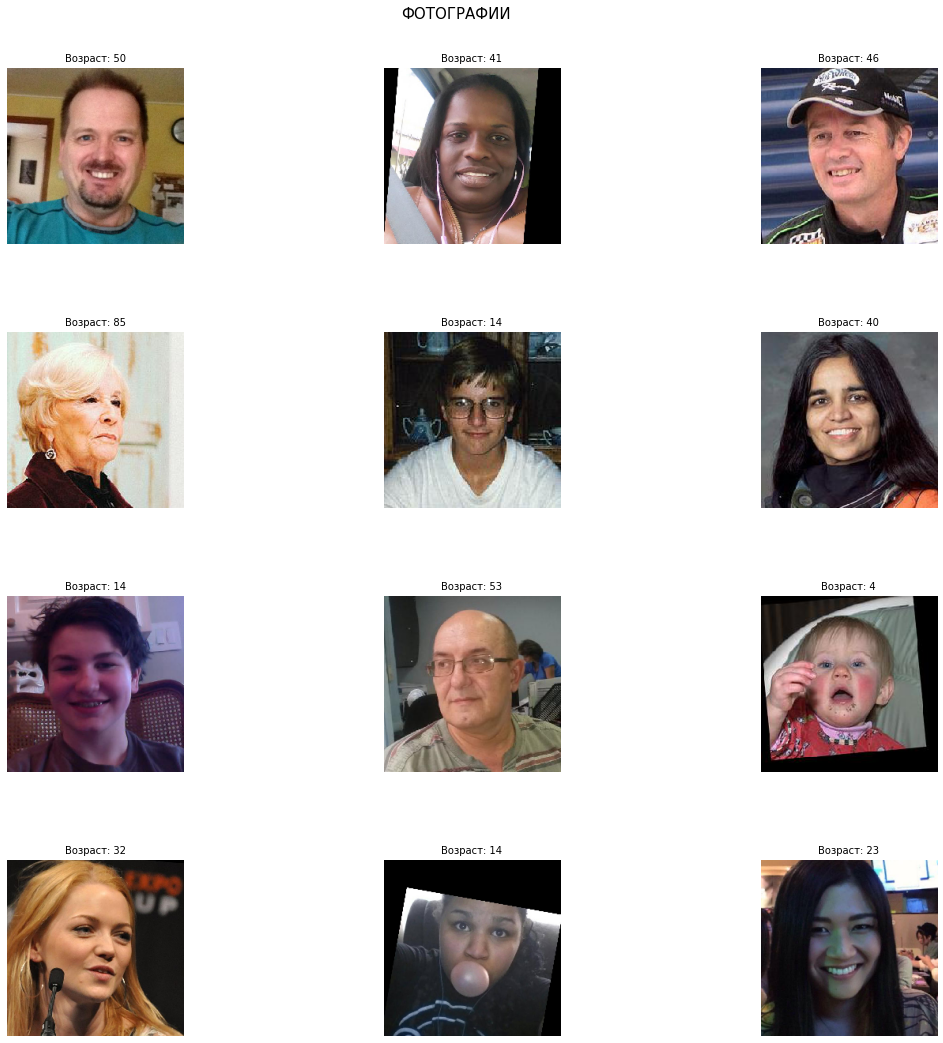

In [39]:
position = 0
num_region = None
plt.figure(figsize=[18, 21])
plt.subplots_adjust(top=0.94, wspace=0.5, hspace=0.5)
plt.suptitle('ФОТОГРАФИИ', fontsize=15)
plt.grid(b=None)


for i in range(12):
    position += 1
    plt.subplot(5, 3, position)
    plt.title(f'Возраст: {target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.axis('off')
    
plt.show()

Фотографии, представленные в датасете, имеют самый разный контекст. Также на них могут быть представлены посторонние предметы, закрывающие часть лица. Хочу отметить, что некоторые фотографии были явно повернуты. Возможно, целью этого было разместить овал лица вертикально.

**Вывод**: <br>
1) В датасете 7591 изображение размером (224, 224, 3). Это не так много для нашей задачи, поэтому для обучения необходимо прибегнуть к увеличению выборки через аугментацию; <br>
2) Выборка неравномерна и имеет выбросы. На гистограмме заметны множество пиков, и вместе с этим для возраста 7-13 лет данных достаточно мало. <br>
3) Фотографии, представленные в выборке, имеют самый различный контекст. Лица могут быть частично перекрыты (очками, наушниками, другими предметами) или повернуты.

## Обучение модели

Далее представлен код, имеющий четыре функции: <br>
1) load_train - загрузка обучающей выборки. Также в ней изображения подвергаются аугментации. Стоит отметить, что я решил отказаться от наклона фотографии и вертикального отображения. <br>
2) load_test - загрузка тетсовой выборки. Без аугментации. <br>
3) create_model - создание модели, имеющей архитектуру ResNet50. <br>
4) train_model - обучение модели.

```python

# Загрузка библиотек
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.2,
                                       rescale=1/255,
                                       horizontal_flip=True,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                       directory=path + 'final_files/',
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                     directory=path + 'final_files/',
                                                     x_col='file_name',
                                                     y_col='real_age',
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='raw',
                                                     subset='validation',
                                                     seed=12345)

    return test_gen_flow

def create_model(input_shape):
    # Путь к готовым весам модели ResNet50
    path = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    
    # "Костяк" модели ResNet50
    backbone = ResNet50(input_shape=input_shape, weights=path, include_top=False)
    
    model = Sequential()
    model.add(backbone)
    
    # Дропаут используется для уменьшения влияния переобучения
    model.add(Dropout(0.35))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    # Зачастую нейронные сети с функцией потерь MSE обучаются быстрее. Метрикой является MAE.
    model.compile(loss='mse', optimizer=Adam(lr=0.0001), metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=52,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```
Train for 190 steps, validate for 48 steps
Epoch 1/52
190/190 - 109s - loss: 264.1151 - mae: 11.6518 - val_loss: 1016.6242 - val_mae: 27.0658
Epoch 2/52
190/190 - 100s - loss: 92.2419 - mae: 7.2404 - val_loss: 919.8705 - val_mae: 25.3414
Epoch 3/52
190/190 - 101s - loss: 68.6643 - mae: 6.2645 - val_loss: 372.9685 - val_mae: 14.3699
Epoch 4/52
190/190 - 98s - loss: 57.4408 - mae: 5.8012 - val_loss: 102.7955 - val_mae: 7.5824
Epoch 5/52
190/190 - 93s - loss: 48.3510 - mae: 5.3302 - val_loss: 90.7039 - val_mae: 7.1121
Epoch 6/52
190/190 - 98s - loss: 43.6417 - mae: 5.0557 - val_loss: 103.9876 - val_mae: 7.8128
Epoch 7/52
190/190 - 97s - loss: 37.1159 - mae: 4.7056 - val_loss: 67.2391 - val_mae: 6.1314
Epoch 8/52
190/190 - 100s - loss: 32.9583 - mae: 4.4517 - val_loss: 71.8343 - val_mae: 6.1817
Epoch 9/52
190/190 - 99s - loss: 29.2596 - mae: 4.1838 - val_loss: 92.5366 - val_mae: 7.3611
Epoch 10/52
190/190 - 100s - loss: 26.5048 - mae: 3.9867 - val_loss: 69.7491 - val_mae: 5.9239
Epoch 11/52
190/190 - 100s - loss: 24.9044 - mae: 3.8632 - val_loss: 73.1270 - val_mae: 6.5456
Epoch 12/52
190/190 - 98s - loss: 22.1895 - mae: 3.6648 - val_loss: 77.3921 - val_mae: 6.3689
Epoch 13/52
190/190 - 98s - loss: 19.7115 - mae: 3.4141 - val_loss: 64.0872 - val_mae: 5.9487
Epoch 14/52
190/190 - 99s - loss: 17.8848 - mae: 3.2683 - val_loss: 62.7823 - val_mae: 5.8016
Epoch 15/52
190/190 - 99s - loss: 16.9286 - mae: 3.1712 - val_loss: 66.6706 - val_mae: 6.0260
Epoch 16/52
190/190 - 94s - loss: 15.1804 - mae: 2.9883 - val_loss: 65.3392 - val_mae: 5.9792
Epoch 17/52
190/190 - 95s - loss: 13.9830 - mae: 2.8615 - val_loss: 62.5930 - val_mae: 5.7362
Epoch 18/52
190/190 - 100s - loss: 13.9267 - mae: 2.8610 - val_loss: 72.9441 - val_mae: 6.0862
Epoch 19/52
190/190 - 101s - loss: 13.2404 - mae: 2.7931 - val_loss: 65.0189 - val_mae: 5.9519
Epoch 20/52
190/190 - 101s - loss: 12.0743 - mae: 2.6569 - val_loss: 72.4702 - val_mae: 6.1269
Epoch 21/52
190/190 - 95s - loss: 11.1702 - mae: 2.5570 - val_loss: 60.6928 - val_mae: 5.7428
Epoch 22/52
190/190 - 94s - loss: 10.7856 - mae: 2.5139 - val_loss: 59.4578 - val_mae: 5.5406
Epoch 23/52
190/190 - 97s - loss: 10.9518 - mae: 2.5210 - val_loss: 69.4397 - val_mae: 6.0860
Epoch 24/52
190/190 - 99s - loss: 10.9537 - mae: 2.5036 - val_loss: 61.9354 - val_mae: 5.7562
Epoch 25/52
190/190 - 99s - loss: 9.8870 - mae: 2.4113 - val_loss: 73.8261 - val_mae: 6.1376
Epoch 26/52
190/190 - 95s - loss: 9.5320 - mae: 2.3676 - val_loss: 59.5319 - val_mae: 5.5763
Epoch 27/52
190/190 - 98s - loss: 10.0070 - mae: 2.3921 - val_loss: 73.2641 - val_mae: 6.4337
Epoch 28/52
190/190 - 96s - loss: 9.4896 - mae: 2.3487 - val_loss: 68.6334 - val_mae: 6.0340
Epoch 29/52
190/190 - 96s - loss: 8.9427 - mae: 2.2937 - val_loss: 58.8951 - val_mae: 5.5858
Epoch 30/52
190/190 - 98s - loss: 8.4380 - mae: 2.2280 - val_loss: 61.1743 - val_mae: 5.7829
Epoch 31/52
190/190 - 98s - loss: 9.1026 - mae: 2.3264 - val_loss: 61.0611 - val_mae: 5.7083
Epoch 32/52
190/190 - 97s - loss: 8.9504 - mae: 2.2738 - val_loss: 58.9876 - val_mae: 5.6292
Epoch 33/52
190/190 - 98s - loss: 8.7422 - mae: 2.2343 - val_loss: 58.0372 - val_mae: 5.5823
Epoch 34/52
190/190 - 96s - loss: 8.8140 - mae: 2.2428 - val_loss: 60.9296 - val_mae: 5.6810
Epoch 35/52
190/190 - 95s - loss: 7.8936 - mae: 2.1463 - val_loss: 60.4665 - val_mae: 5.5660
Epoch 36/52
190/190 - 97s - loss: 7.3263 - mae: 2.0822 - val_loss: 60.6311 - val_mae: 5.7240
Epoch 37/52
190/190 - 97s - loss: 7.5524 - mae: 2.0937 - val_loss: 66.5345 - val_mae: 5.8682
Epoch 38/52
190/190 - 98s - loss: 8.1072 - mae: 2.1952 - val_loss: 64.6479 - val_mae: 5.8493
Epoch 39/52
190/190 - 95s - loss: 7.6953 - mae: 2.1097 - val_loss: 59.7036 - val_mae: 5.6033
Epoch 40/52
190/190 - 97s - loss: 7.2358 - mae: 2.0585 - val_loss: 59.0541 - val_mae: 5.5628
Epoch 41/52
190/190 - 96s - loss: 7.0343 - mae: 2.0112 - val_loss: 57.4204 - val_mae: 5.4557
Epoch 42/52
190/190 - 94s - loss: 6.7356 - mae: 1.9810 - val_loss: 58.1754 - val_mae: 5.6614
Epoch 43/52
190/190 - 94s - loss: 6.8717 - mae: 1.9975 - val_loss: 60.2457 - val_mae: 5.5936
Epoch 44/52
190/190 - 94s - loss: 6.9316 - mae: 2.0130 - val_loss: 60.0497 - val_mae: 5.7290
Epoch 45/52
190/190 - 94s - loss: 6.8558 - mae: 1.9956 - val_loss: 56.5174 - val_mae: 5.5046
Epoch 46/52
190/190 - 95s - loss: 6.8452 - mae: 1.9883 - val_loss: 58.5585 - val_mae: 5.4964
Epoch 47/52
190/190 - 94s - loss: 6.5524 - mae: 1.9317 - val_loss: 68.7165 - val_mae: 5.9779
Epoch 48/52
190/190 - 95s - loss: 6.5618 - mae: 1.9188 - val_loss: 55.4890 - val_mae: 5.3505
Epoch 49/52
190/190 - 94s - loss: 6.5505 - mae: 1.9446 - val_loss: 65.6141 - val_mae: 5.7011
Epoch 50/52
190/190 - 97s - loss: 6.2270 - mae: 1.8988 - val_loss: 57.8244 - val_mae: 5.4852
Epoch 51/52
190/190 - 98s - loss: 6.2570 - mae: 1.9123 - val_loss: 58.8439 - val_mae: 5.6700
Epoch 52/52
190/190 - 98s - loss: 5.9778 - mae: 1.8592 - val_loss: 58.3107 - val_mae: 5.5285
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 9s - loss: 58.3107 - mae: 5.5285
Test MAE: 5.5285

```

Итак, краткий анализ обучения модеои на GPU: <br>
Модель достигла необходимого значения MAE уже на 7 эпохе, затратив на обучение менее 15 минут времени. Последующие эпохи снизили MAE до 5.6 в среднем.

## Анализ обученной модели

Выводы: <br>
Используя готовые инструменты DL и немного практических знаний, можно достаточно быстро построить нейросеть, способную определять возраст человека по фотографии. В открытом доступе находится огромное множество датасетов, на которых можно обучить нейросеть под самые разные задачи. <br>
Для выполнения задачи определения возраста человека по фото со средним абсолютным отклонением в 7 лет потребовалось: <br>
1) Размеченный датасет с фотографиями людей (7500 фотографий); <br>
2) Готовая архитектура ResNet50, импортированная из библиотеки в открытом доступе; <br>
3) n-ое количество GPU; <br>
4) Немного времени и терпения. <br>

В дальнейшем хотелось бы попробовать немного изменить датасет: добавить больше людей возраста 10-25 и 40-100 лет, чтобы модель не обучалась преимущественно на людях среднего возраста.